In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# Load dataset
df = pd.read_csv('quarterly_stock_sales.csv')
print(f"Dataset Loaded: {df.shape[0]} rows and {df.shape[1]} columns.")

# 1. Drop rows without CustomerID for cleaner profiling (optional based on scope)
df = df.dropna(subset=['CustomerID'])

# 2. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 3. Create TotalSales column
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# 4. Extract Quarter and Year
df['Quarter'] = df['InvoiceDate'].dt.to_period('Q')

# 5. Identify Cancellations (Detection Prep)
df['IsCancelled'] = df['InvoiceNo'].str.startswith('C', na=False)

print(df[['InvoiceNo', 'TotalSales', 'Quarter', 'IsCancelled']].head())

Dataset Loaded: 541909 rows and 9 columns.
  InvoiceNo  TotalSales Quarter  IsCancelled
0    536365       15.30  2010Q4        False
1    536365       20.34  2010Q4        False
2    536365       22.00  2010Q4        False
3    536365       20.34  2010Q4        False
4    536365       20.34  2010Q4        False


C:\Users\Admin\AppData\Local\Temp\ipykernel_6352\2539373379.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()


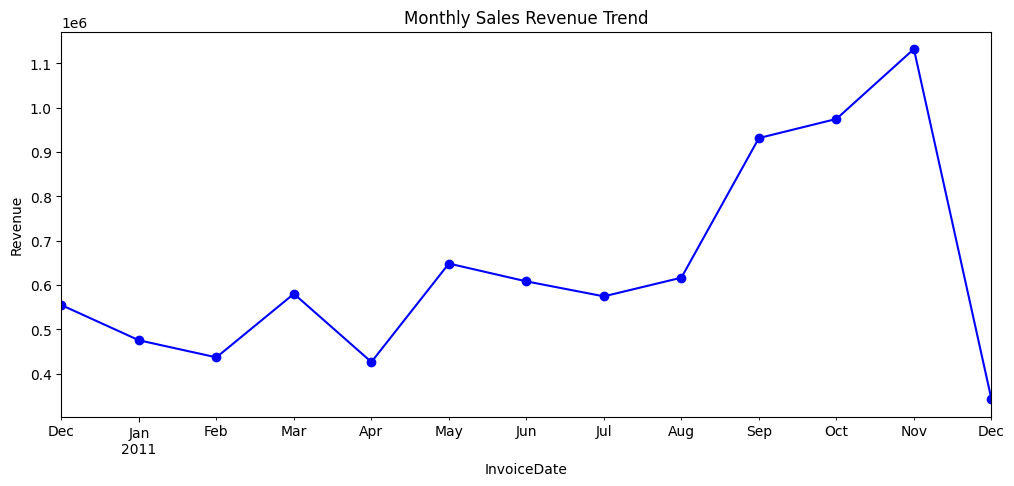

In [8]:
# Monthly Sales Trend
monthly_sales = df.resample('M', on='InvoiceDate')['TotalSales'].sum()
plt.figure(figsize=(12,5))
monthly_sales.plot(kind='line', marker='o', color='b')
plt.title('Monthly Sales Revenue Trend')
plt.ylabel('Revenue')
plt.show()

In [9]:
# Grouping by Quarter
quarterly_perf = df.groupby('Quarter').agg({
    'TotalSales': 'sum',
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique'
}).rename(columns={'InvoiceNo': 'OrderCount', 'CustomerID': 'UniqueCustomers'})

# Calculate Average Order Value (AOV)
quarterly_perf['AOV'] = quarterly_perf['TotalSales'] / quarterly_perf['OrderCount']

print(quarterly_perf)

          TotalSales  OrderCount  UniqueCustomers         AOV
Quarter                                                      
2010Q4    554604.020        1708              948  324.709614
2011Q1   1491585.140        4057             1812  367.657170
2011Q2   1682312.091        4940             2024  340.549006
2011Q3   2122046.853        5215             2196  406.912148
2011Q4   2449517.710        6270             2601  390.672681


In [10]:
# 1. Detecting Price Outliers (Items priced way above the norm)
mean_price = df['UnitPrice'].mean()
std_price = df['UnitPrice'].std()
outliers = df[df['UnitPrice'] > (mean_price + 3 * std_price)]

# 2. Detecting High-Return Customers
returns = df[df['IsCancelled'] == True]
suspicious_customers = returns.groupby('CustomerID')['InvoiceNo'].count().sort_values(ascending=False).head(10)

print("Top 10 Customers by Return Frequency:")
print(suspicious_customers)

Top 10 Customers by Return Frequency:
CustomerID
14911.0    226
17841.0    136
17511.0    113
15311.0    112
12607.0    101
14410.0     93
13798.0     90
14606.0     82
13113.0     79
12471.0     71
Name: InvoiceNo, dtype: int64


In [11]:
# Simple Moving Average for next quarter forecast
forecast = quarterly_perf['TotalSales'].rolling(window=2).mean().iloc[-1]
print(f"Simple Forecast for next period: {forecast:.2f}")

Simple Forecast for next period: 2285782.28


In [12]:
summary_report = {
    "Total Annual Revenue": df['TotalSales'].sum(),
    "Average Quarterly Growth": quarterly_perf['TotalSales'].pct_change().mean() * 100,
    "Flagged Anomaly Count": len(outliers),
    "Total Returns Value": df[df['TotalSales'] < 0]['TotalSales'].sum()
}

for key, value in summary_report.items():
    print(f"{key}: {value:,.2f}")

Total Annual Revenue: 8,300,065.81
Average Quarterly Growth: 55.83
Flagged Anomaly Count: 149.00
Total Returns Value: -611,342.09
